In [21]:
import numpy
from time import time
from math import *
from scipy.fftpack import *
from matplotlib import pyplot, cm
from matplotlib import rcParams
import matplotlib.patches as mpatches
%matplotlib inline
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 8

# Transformada Rápida de Fourier
                                                                                Matías Martínez Alvarado
                                                                                201160009-6

## El Problema

Consideremos la ecuación de Poisson:

$$ \frac{\partial^2 \phi}{\partial x^2}+\frac{\partial^2 \phi}{\partial y^2} = \frac{1}{\pi^2}\left(30\left(\left(\frac{x}{\pi}\right)^2-\frac{x}{\pi}\right)+30\left(\left(\frac{y}{\pi}\right)^2-\frac{y}{\pi}\right)-4 \pi^2 \left(\frac{x}{\pi}-1\right)\sin(2y)\right) $$

con condiciones de contorno:

$$ \phi(0, y)=\phi(\pi, y)=\phi(x, 0)=\phi(x, \pi) = 0 $$

que puede reescribirse como:

$$ \nabla^2 \phi = f(x,y) $$

donde $$f(x,y) = \frac{1}{\pi^2}\left(30\left(\left(\frac{x}{\pi}\right)^2-\frac{x}{\pi}\right)+30\left(\left(\frac{y}{\pi}\right)^2-\frac{y}{\pi}\right)-4 \pi^2 \left(\frac{x}{\pi}-1\right)\sin(2y)\right) $$

In [22]:
N = 128
x = numpy.linspace(0., pi, N)
y = numpy.linspace(0., pi, N)
h = pi/(N-1)

In [23]:
def f(x, y):
    N = len(x)
    f = numpy.zeros((N, N))
    for i in range(N):
        for j in range(N):
            f[i, j] = (1./pi**2)*(30.*((x[i]/pi)\
                                **2-x[i]/pi)+30.*((y[j]/pi)**2.-y[j]/pi)-4*(pi**2.)\
                                  *(x[i]/pi-1.)*sin(2*y[j]))
    return f

Además, cargamos las definiciones de las trasnformadas del seno con el siguiente comando:

In [24]:
from numpy import empty,arange,exp,real,imag,pi
from numpy.fft import rfft,irfft

# 1D DST Type-I

def dst(y):
    N = len(y)
    y2 = empty(2*N,float)
    y2[0] = y2[N] = 0.0
    y2[1:N] = y[1:]
    y2[:N:-1] = -y[1:]
    a = -imag(rfft(y2))[:N]
    a[0] = 0.0

    return a

# 1D inverse DST Type-I

def idst(a):
    N = len(a)
    c = empty(N+1,complex)
    c[0] = c[N] = 0.0
    c[1:N] = -1j*a[1:]
    y = irfft(c)[:N]
    y[0] = 0.0

    return y

# 2D DST

def dst2(y):
    M = y.shape[0]
    N = y.shape[1]
    a = empty([M,N],float)
    b = empty([M,N],float)

    for i in range(M):
        a[i,:] = dst(y[i,:])
    for j in range(N):
        b[:,j] = dst(a[:,j])

    return b

# 2D inverse DST

def idst2(b):
    M = b.shape[0]
    N = b.shape[1]
    a = empty([M,N],float)
    y = empty([M,N],float)

    for i in range(M):
        a[i,:] = idst(b[i,:])
    for j in range(N):
        y[:,j] = idst(a[:,j])

    return y

## Solución Analítica

La solución analítica de este problema está dada por:
$$ \phi(x, y) = 15 \left(\left(\frac{x}{\pi}\right)^2-\frac{x}{\pi}\right) \left(\left(\frac{y}{\pi}\right)^2-\frac{y}{\pi}\right)-\sin(2y) \frac{\sinh(2 \pi (\frac{x}{\pi}-1))}{\sinh(2 \pi)}+\left(\frac{x}{\pi}-1\right)\sin(2y) $$

In [25]:
def phi_ana(N):
    x = numpy.linspace(0., pi, N)
    y = numpy.linspace(0., pi, N)
    f = numpy.zeros((N, N))
    for i in range(N):
        for j in range(N):
            f[i, j] = 15.*((x[i]/pi)**2-x[i]/pi)*((y[j]/pi)**2.\
                                -y[j]/pi)- (sin(2*y[j])*sinh(2*pi*(x[i]/pi-1.)))\
                                /sinh(2*pi)+(x[i]/pi-1.)*sin(2*y[j])
    return f

En la siguiente figura podemos ver un gráfico de la solución.

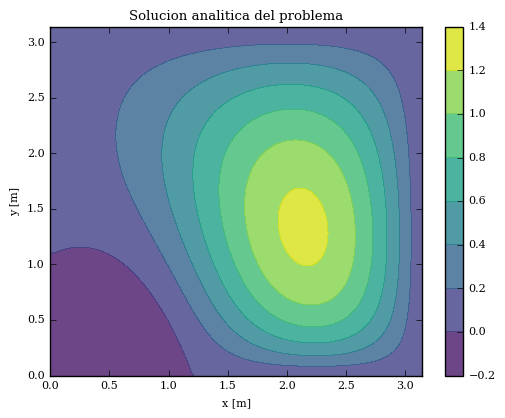

In [26]:
phi_analitica = phi_ana(128)

fig = pyplot.figure(figsize=(6,4.5), dpi = 20);
pyplot.contourf(x, y, phi_analitica, alpha = 0.8, cmap = cm.viridis)
pyplot.colorbar()
pyplot.title('Solucion analitica del problema')
pyplot.xlabel('x [m]')
pyplot.ylabel('y [m]');

## Solución por Método Espectral

Para usar el método espectral, es necesario plantear las transformadas del seno en dos simensiones de las variables $\phi$ y $f$:

$$ f_{i, j} = \sum^{n}_{k=0} \sum^{n}_{l=0} F_{k, l} \sin\left(kx_i \right)\sin\left(ly_j\right) $$

$$ \phi_{i, j} = \sum^{n}_{k=0} \sum^{n}_{l=0} \Phi_{k, l} \sin\left(kx_i \right)\sin\left(ly_j\right)$$

si derivamos $\phi_{i,j}$ respecto a $x_i$, obtenemos

$$ \frac{\partial \phi_{i,j}}{\partial x_i} = \sum^{n}_{k=0} \sum^{n}_{l=0} -k  \Phi_{k, l} \cos\left(kx_i \right)\sin\left(ly_j\right) $$

$$ \frac{\partial^2 \phi_{i,j}}{\partial x_i^2} = \sum^{n}_{k=0} \sum^{n}_{l=0} -k²  \Phi_{k, l} \sin\left(kx_i \right)\sin\left(ly_j\right) $$

análogamente, si derivamos dos veces respecto a $y_j$

$$ \frac{\partial^2 \phi_{i,j}}{\partial y_j^2} = \sum^{n}_{k=0} \sum^{n}_{l=0} -l²  \Phi_{k, l} \sin\left(kx_i \right)\sin\left(ly_j\right) $$

reemplazando estas expresiones en la ecuación diferencia original obtenemos:

$$ \sum^{n}_{k=0} \sum^{n}_{l=0} -k²  \Phi_{k, l} \sin\left(kx_i \right)\sin\left(ly_j\right) + \sum^{n}_{k=0} \sum^{n}_{l=0} -l²  \Phi_{k, l} \sin\left(kx_i \right)\sin\left(ly_j\right) = \sum^{n}_{k=0} \sum^{n}_{l=0} F_{k, l} \sin\left(kx_i \right)\sin\left(ly_j\right) $$

$$ \implies \sum^{n}_{k=0} \sum^{n}_{l=0} -(k^2+l^2)  \Phi_{k, l} \sin\left(kx_i \right)\sin\left(ly_j\right) = \sum^{n}_{k=0} \sum^{n}_{l=0} F_{k, l} \sin\left(kx_i \right)\sin\left(ly_j\right) $$

para que esta expresión sea verdad para cada valor de $k$, $l$, tenemos finalmente que:

$$\Phi_{k, l} =- \frac{F_{k, l}}{k^2+l^2}$$

el siguiente código resuelve el problema utilizando la expresión derivada

In [27]:
def espectral(N):
    x = numpy.linspace(0., pi, N)
    y = numpy.linspace(0., pi, N)
    fvalues = f(x, y)
    fvalues_t = dst2(fvalues)
    phi_t = numpy.zeros((N, N))
    for k in range(1, N):
        for l in range(1, N):
            phi_t[k,l] = fvalues_t[k,l]/(-k**2-l**2)
    phi = idst2(phi_t)
    return phi

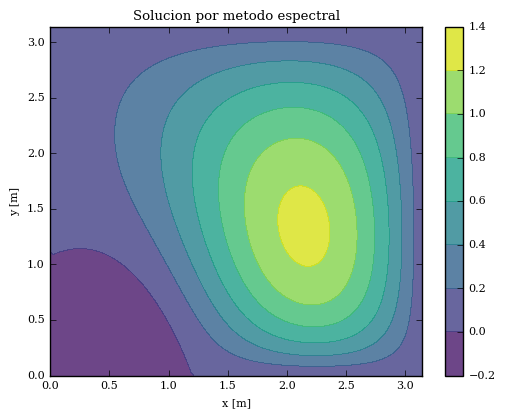

In [28]:
phi = espectral(128)
N = len(phi)
x = numpy.linspace(0., pi, N) #endpoint=False
y = numpy.linspace(0., pi, N)
fig = pyplot.figure(figsize=(6,4.5), dpi = 20);
pyplot.contourf(x, y, phi, alpha = 0.8, cmap = cm.viridis)
pyplot.colorbar()
pyplot.title('Solucion por metodo espectral')
pyplot.xlabel('x [m]')
pyplot.ylabel('y [m]');

## Solución por diferencias finitas (2D DST)

Al hacer una discretización de problema en diferencias finitas centradas obtenemos

$$ -\phi_{i-1, j} - \phi_{i, j-1} + 4 \phi_{i, j} -\phi_{i+1, j} - \phi_{i, j+1} = -f_{i,j} * h^2 $$

si hacemos $x_{i} = ih$, $ y_{j} = jh $, donde $h = \frac{\pi}{n}$ y además, usamos la transformada de seno, obtenemos para $\phi_{i, j}$:

$$ f_{i, j} = \sum^{n}_{k=0} \sum^{n}_{l=0} F_{k, l} \sin\left(\frac{k \pi i}{n} \right)\sin\left(\frac{l \pi j }{n}\right) $$

$$ \phi_{i, j} = \sum^{n}_{k=0} \sum^{n}_{l=0} \Phi_{k, l} \sin\left(\frac{k \pi i}{n} \right)\sin\left(\frac{l \pi j }{n}\right) $$

y por lo tanto:

$$ \phi_{i-1, j} = \sum^{n}_{k=0} \sum^{n}_{l=0} \Phi_{k, l} \sin\left(\frac{k \pi i}{n}-\frac{k \pi}{n} \right)\sin\left(\frac{l \pi j }{n}\right) = \sum^{n}_{k=0} \sum^{n}_{l=0} \Phi_{k, l} \left(\sin\left(\frac{k \pi i}{n}\right)\cos\left(\frac{k \pi}{n}\right)-\cos\left(\frac{k \pi i}{n}\right)\sin\left(\frac{k \pi}{n}\right)\right)\sin\left(\frac{l \pi j }{n}\right) $$

$$\implies \phi_{i-1, j} = \sum^{n}_{k=0} \sum^{n}_{l=0} \Phi_{k, l} \left( \sin(kx_i)\cos(kh)-\cos(kx_i)\sin(kh) \right) \sin(ly_{j})$$

del mismo modo:

$$\phi_{i+1, j} = \sum^{n}_{k=0} \sum^{n}_{l=0} \Phi_{k, l} \left( \sin(kx_i)\cos(kh)+\cos(kx_i)\sin(kh) \right) \sin(ly_{j})$$

$$\phi_{i, j-1} = \sum^{n}_{k=0} \sum^{n}_{l=0} \Phi_{k, l} \left( \sin(ly_j)\cos(lh)-\cos(ly_j)\sin(lh) \right) \sin(kx_{i})$$

$$\phi_{i, j+1} = \sum^{n}_{k=0} \sum^{n}_{l=0} \Phi_{k, l} \left( \sin(ly_j)\cos(lh)+\cos(ly_j)\sin(lh) \right) \sin(kx_{i})$$

al introducir estas expresiones en la discretización, y con un poco de álgebra, obtenemos:

$$ \sum^{n}_{k=0} \sum^{n}_{l=0} \Phi_{k, l} \left( -2\cos(kh)+4-2\cos(lh) \right) \sin(kx_i)\sin(ly_j) = -h^2 \sum^{n}_{k=0} \sum^{n}_{l=0} F_{k, l} \sin(kx_i)\sin(ly_j) $$

por supuesto, si queremos que esta expresión sea cierta para cada $k$, $l$, entonces,

$$\left( -2\cos(kh)+4-2\cos(lh) \right) \Phi_{k, l}  = -h^2  F_{k, l} $$


$$\implies \Phi_{k, l}  = \frac{h^2}{ 2(\cos(kh)+\cos(lh))-4} F_{k, l}$$

$$\implies \Phi_{k, l}  = \frac{h^2}{ 4 \cos(\frac{k+l}{2} h) \cos(\frac{k-l}{2} h)-4} F_{k, l}$$

El siguiente código utiliza esta expresión para el cálculo de la solución.

In [29]:
def df2D(N):
    x = numpy.linspace(0., pi, N)
    y = numpy.linspace(0., pi, N)
    h = pi/(N-1)
    fvalues = f(x, y)
    fvalues_t = dst2(fvalues)
    phi_t = numpy.zeros((N, N)) # calculamos phi_t(f_t))
    for k in range(1, N-1):
        for l in range(1, N-1):
            phi_t[k,l] = fvalues_t[k,l]*(h**2/(4*cos((k+l)*h/2)*cos((k-l)*h/2)-4.))
    phi = idst2(phi_t)
    return phi

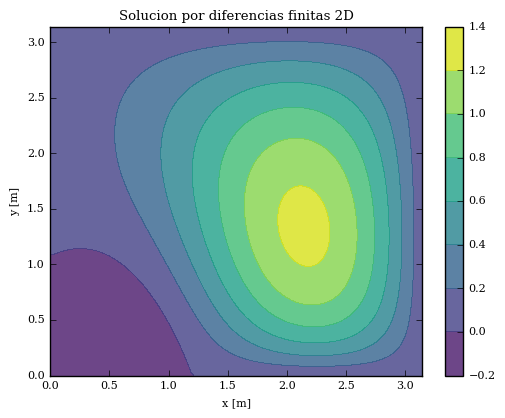

In [30]:
phi = df2D(128)
N = len(phi)
x = numpy.linspace(0., pi, N)
y = numpy.linspace(0., pi, N)
fig = pyplot.figure(figsize=(6,4.5), dpi = 20);
pyplot.contourf(x, y, phi, alpha = 0.8, cmap = cm.viridis)
pyplot.colorbar()
pyplot.title('Solucion por diferencias finitas 2D')
pyplot.xlabel('x [m]')
pyplot.ylabel('y [m]');

## Solución por diferencias finitas (1D DST)

En este caso, tenemos la misma discretización del espacio: 

$$ -\phi_{i-1, j} - \phi_{i, j-1} + 4 \phi_{i, j} -\phi_{i+1, j} - \phi_{i, j+1} = -f_{i,j} * h^2 $$

pero ahora usaremos la DST en solo una dimensión, por lo tanto el contador $i$ pasará a $k$, pero j quedará invariante:

$$ \phi_{i, j} = \sum^{n}_{k=0} \Phi_{k, j} \sin\left(\frac{k \pi i}{n} \right) $$

$$ f_{i, j} = \sum^{n}_{k=0} F_{k, j} \sin\left(\frac{k \pi i}{n} \right) $$

usando los resultados anteriores, tenemos:

$$ \phi_{i-1, j} = \sum^{n}_{k=0} \Phi_{k, j} \left( \sin(kx_i) \cos(kh) - \cos(kx_i) \sin(kh) \right) $$
$$ \phi_{i+1, j} = \sum^{n}_{k=0} \Phi_{k, j} \left( \sin(kx_i) \cos(kh) + \cos(kx_i) \sin(kh) \right) $$
$$ \phi_{i, j-1} = \sum^{n}_{k=0} \Phi_{k, j-1} \sin(kx_i) $$
$$ \phi_{i, j+1} = \sum^{n}_{k=0} \Phi_{k, j-1} \sin(kx_i) $$

desarollando el álgebra de introducir estas expresiones en la discretización obtenemos:

$$ -\Phi_{k, j-1} + (4-2\cos(kh)) \Phi_{k,j} - \Phi_{k,j+1} = -h^2 F_{k,j} $$

La última expresión obtenida representa una familia de $N$ sistemas de ecuaciones lineales, con matrices de $N \times N$ (un sistema para cada valor de $k$). Definimos un algoritmo para la resolución de sistemas de ecuaciones con matrices tridiagonales:

In [31]:
def TDMAsolver(a, b, c, d):
    nf = len(a)
    ac, bc, cc, dc = map(numpy.array, (a, b, c, d))
    for it in xrange(1, nf):
        mc = ac[it]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1]

    xc = ac
    xc[-1] = dc[-1]/bc[-1]

    for il in xrange(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    del bc, cc, dc

    return xc

In [32]:
def df1D(N):
    x = numpy.linspace(0., pi, N)
    y = numpy.linspace(0., pi, N)
    h = pi/(N-1)
    fvalues = f(x, y)
    f_t1D = numpy.zeros((N, N))
    for j in range(N):
        f_t1D[:, j] = dst(fvalues[:, j])
    phi_t1D = numpy.zeros((N, N))
    a = -numpy.ones(N)
    b = numpy.zeros(N)
    for k in range(N):
        b.fill(4. - 2.*cos(k*h))
        d = numpy.zeros(N)
        for j in range(N):
            d[j] = -h**2 * f_t1D[k, j]
        phi_t1D[k, :] = TDMAsolver(a, b, a, d)
    phi = numpy.zeros((N, N))
    for j in range(N):
        phi[:, j] = idst(phi_t1D[:, j])
    return phi

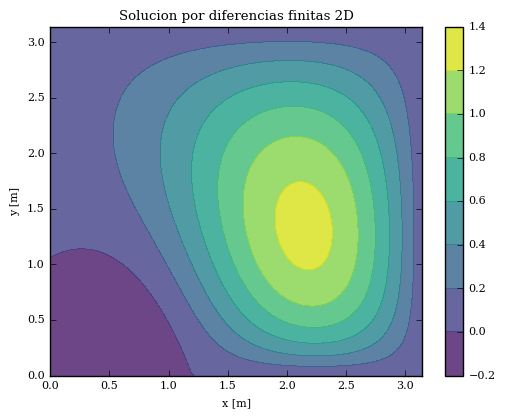

In [33]:
phi = df1D(128)
N = len(phi)
x = numpy.linspace(0., pi, N)
y = numpy.linspace(0., pi, N)
fig = pyplot.figure(figsize=(6,4.5), dpi = 20);
pyplot.contourf(x, y, phi, alpha = 0.8, cmap = cm.viridis)
pyplot.colorbar()
pyplot.title('Solucion por diferencias finitas 2D')
pyplot.xlabel('x [m]')
pyplot.ylabel('y [m]');

## Convergencia del error

Para analizar la convergencia del error usaremos la norma infinito:

In [34]:
def L2_error(f, f_exact):
    return numpy.sqrt(numpy.sum((f-f_exact)**2)/numpy.sum(f_exact**2))

Calcularemos los errores para 4, 8, 16, 32, 64, 128, 256 y 512 nodos.

In [35]:
malla = numpy.array([4, 8, 16, 32, 64, 128, 256, 512])
error_espectral = numpy.zeros(8)
error_df2D = numpy.zeros(8)
error_df1D = numpy.zeros(8)
for i in range(8):
    error_espectral[i] = L2_error(espectral(malla[i]), phi_ana(malla[i]))
    error_df2D[i] = L2_error(df2D(malla[i]), phi_ana(malla[i]))
    error_df1D[i] = L2_error(df1D(malla[i]), phi_ana(malla[i]))

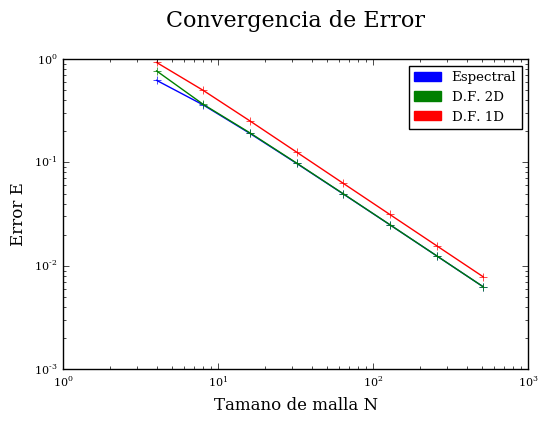

In [36]:
pyplot.plot(malla, error_espectral, 'b-+')
pyplot.plot(malla, error_df2D, 'g-+')
pyplot.plot(malla, error_df1D, 'r-+')
pyplot.xlabel('Tamano de malla N', fontsize = 12)
pyplot.ylabel('Error E', fontsize = 12)
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.title('Convergencia de Error\n', fontsize = 16)
red = mpatches.Patch(color='red', label='D.F. 1D')
blue = mpatches.Patch(color='blue', label='Espectral')
green = mpatches.Patch(color='green', label='D.F. 2D')
pyplot.legend(handles=[blue, green, red])
pyplot.show()

Los tres métodos comparten un error asociado a la FFT (en este caso DST), pues una aproximación de la transformada continua de fuorier. Además, los métodos mixtos, incluyen un error de orden $O(h^2)$ por la utilización de diferencias finitas.

## Complejidad algorítmica

In [37]:
malla = numpy.array([4, 8, 16, 32, 64, 128, 256, 512])
time_espectral = numpy.zeros(8)
time_df2D = numpy.zeros(8)
time_df1D = numpy.zeros(8)
for i in range(8):
    t0 = time()
    espectral(malla[i])
    t1 = time()
    df2D(malla[i])
    t2 = time()
    df1D(malla[i])
    t3 = time()
    time_df1D[i] = t3 - t2
    time_df2D[i] = t2 - t1
    time_espectral[i] = t1 - t0

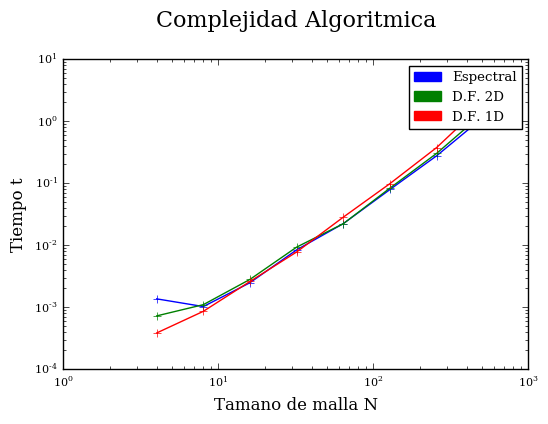

In [38]:
pyplot.plot(malla, time_espectral, 'b-+')
pyplot.plot(malla, time_df2D, 'g-+')
pyplot.plot(malla, time_df1D, 'r-+')
pyplot.xlabel('Tamano de malla N', fontsize = 12)
pyplot.ylabel('Tiempo t', fontsize = 12)
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.title('Complejidad Algoritmica\n', fontsize = 16)
red = mpatches.Patch(color='red', label='D.F. 1D')
blue = mpatches.Patch(color='blue', label='Espectral')
green = mpatches.Patch(color='green', label='D.F. 2D')
pyplot.legend(handles=[blue, green, red])
pyplot.show()

## Espacio en Memoria

El la memoria, hemos almacenado distintas cantidades de datos dependiendo del método. Analizaremos caso a caso.

### Espectral

Analizando el almacenamiento en memoria para cada variable:

\begin{array}{ | l | l | l | l | }
\hline
    variable & tipo & cantidad & peso \\ \hline
	fvalues & float64 & N^2 & 8[B] * N² \\ \hline
	fvalues\_t & float64 & N^2 & 8[B] * N² \\ \hline
	phi\_t & float64 & N^2 & 8[B] * N² \\ \hline
	phi & float64 & N^2 & 8[B] * N² \\ \hline
	  & \  & \  & 32[B] * N²  \\ \hline
\end{array}

### Diferencias Finitas (DST 2D)

Analizando el almacenamiento en memoria para cada variable:

\begin{array}{ | l | l | l | l | }
\hline
    variable & tipo & cantidad & peso \\ \hline
	fvalues & float64 & N^2 & 8[B] * N² \\ \hline
	fvalues\_t & float64 & N^2 & 8[B] * N² \\ \hline
	phi\_t & float64 & N^2 & 8[B] * N² \\ \hline
	phi & float64 & N^2 & 8[B] * N² \\ \hline
	  & \  & \  & 32[B] * N²  \\ \hline
\end{array}

### Diferencias Finitas (DST 1D)

Analizando el almacenamiento en memoria para cada variable:

\begin{array}{ | l | l | l | l | }
\hline
    variable & tipo & cantidad & peso \\ \hline
	fvalues & float64 & N^2 & 8[B] * N² \\ \hline
	f\_t1D & float64 & N^2 & 8[B] * N² \\ \hline
	phi\_t1D & float64 & N^2 & 8[B] * N² \\ \hline
	phi & float64 & N^2 & 8[B] * N² \\ \hline
    a & float32 & N & 4[B] * N \\ \hline
    b & float32 & N & 4[B] * N \\ \hline
    d & float32 & N & 4[B] * N \\ \hline
	  & \  & \  & 32[B] * N² + 12[B] * N  \\ \hline
\end{array}

In [39]:
malla = numpy.array([4, 8, 16, 32, 64, 128, 256])
size_espectral = numpy.zeros(7)
size_df2D = numpy.zeros(7)
size_df1D = numpy.zeros(7)

for i in range(7):
    size_espectral[i] = (32. * malla[i]**2)/1000000.
    size_df2D[i] = (32. * malla[i]**2)/1000000.
    size_df1D[i] = (32. * malla[i]**2 + 12. * malla[i])/1000000.

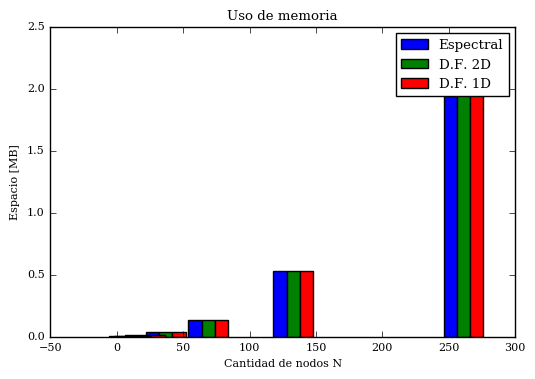

In [40]:
import numpy as np
import matplotlib.pyplot as plt

width = 10
fig, ax = plt.subplots()
rects1 = ax.bar(malla - width, size_espectral, width, color='b')
rects2 = ax.bar(malla, size_df2D, width, color='g')
rects3 = ax.bar(malla + width, size_df1D, width, color='r')

ax.set_ylabel('Espacio [MB]')
ax.set_xlabel('Cantidad de nodos N')
ax.set_title('Uso de memoria')
ax.legend((rects1[0], rects2[0], rects3[0]), ('Espectral', 'D.F. 2D', 'D.F. 1D'))

plt.show()

## Conclusiones

- Debe haber un error en la implementación del método espectral, pues no se obtiene la convergencia esperada.
- En cuanto a complejidad algorítmica y uso de memoria, las tres formas se comportan de forma similar.